<a href="https://colab.research.google.com/github/thedarsideofit/covid19-ar/blob/master/COVID19_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# See the Original  Source >> Towards DataScience - Gianluca Malato
  [Covid-19 infection in Italy. Mathematical models and predictions](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d)

 and the great adaptation from Enrico Ros [adaptation from Enrico Ros](https://colab.research.google.com/drive/16CzLtNCnYq8x3gEBOgg2pMmDQngSD2vG )

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from IPython.display import HTML as html_print
%matplotlib inline

Dataset created from Wikipedia
[Pandemia de enfermedad por coronavirus de 2020 en Argentina](https://es.wikipedia.org/wiki/Pandemia_de_enfermedad_por_coronavirus_de_2020_en_Argentina)


Officially reported in daily morning report from 2020-03-24 

[Daily Report Coronavirus Argentina - Gov. Health](https://www.argentina.gob.ar/coronavirus/informe-diario)

We use this data to cover the negative tests from this tweet
[@Sancho_SA - 2020-03-28](https://twitter.com/Sancho_SA/status/1243875517838868480)

In [2]:
url = "https://raw.githubusercontent.com/thedarsideofit/covid19-ar/master/covid19-ar.csv"
df = pd.read_csv(url)
df

,day,country,recovery,new_cases,deaths,cases,total_negative_tests
0,3/3/20,AR,0.0,1,0,1,NaN
1,3/4/20,AR,0.0,0,0,1,NaN
2,3/5/20,AR,0.0,1,0,2,NaN
3,3/6/20,AR,0.0,6,0,8,NaN
4,3/7/20,AR,0.0,1,1,9,NaN
5,3/8/20,AR,0.0,3,0,12,NaN
6,3/9/20,AR,0.0,5,0,17,NaN
7,3/10/20,AR,0.0,2,0,19,NaN
8,3/11/20,AR,0.0,2,0,21,NaN
9,3/12/20,AR,1.0,10,0,31,NaN


In [3]:
# select 2 columns, rename, and parse the date
#df = df.rename(columns={"data": 'day', "totale_casi": 'cases'})
df = df.loc[:, ['day', 'deaths','cases']]
first_day = datetime(2020, 1, 2) - timedelta(days=1)
print(first_day)
df['day'] = df['day'].map(lambda x: (datetime.strptime(x, '%m/%d/%y') - first_day).days)

df.tail()

2020-01-01 00:00:00


,day,deaths,cases
43,105,115,2571
44,106,122,2669
45,107,129,2758
46,108,132,2839
47,109,134,2941


In [5]:
# the following block is just for displaying the input data, with some unused augmentation
dfG = df.copy()
dfG['cases_diff'] = dfG.diff()['cases']
dfG['cases_growth_%'] = round(dfG['cases_diff'] / (dfG['cases'] - dfG['cases_diff']) * 100, 1)
dfG['date'] = [first_day + timedelta(days = day) for day in dfG['day']]
print("...data for the last 7 days")
dfG[-7:]

...data for the last 7 days


,day,deaths,cases,cases_diff,cases_growth_%,date
41,103,101,2277,69.0,3.1,2020-04-13
42,104,109,2443,166.0,7.3,2020-04-14
43,105,115,2571,128.0,5.2,2020-04-15
44,106,122,2669,98.0,3.8,2020-04-16
45,107,129,2758,89.0,3.3,2020-04-17
46,108,132,2839,81.0,2.9,2020-04-18
47,109,134,2941,102.0,3.6,2020-04-19


Growth in the last two weeks - **chart copied from [This Tweet](https://twitter.com/Francolino_Bear/status/1237227757509021697) by [Francesco Favaro](https://twitter.com/Francolino_Bear)** on 3/10/2020:

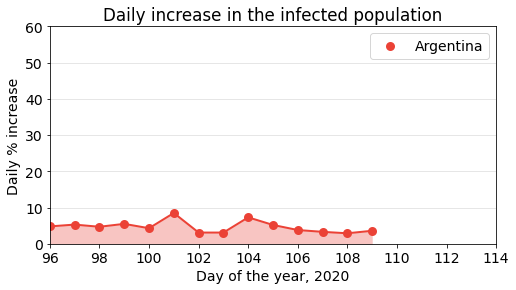

In [6]:
dfg2 = dfG[-14:]
x = dfg2['day'].tolist()
y = dfg2['cases_growth_%'].tolist()

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.figure(figsize=(8, 4))
plt_axes = plt.gca()
plt_axes.grid(axis='y', color=(0.4, 0.4, 0.4), alpha=0.2)
plt.stackplot(x, y, color=(0.92, 0.26, 0.21, 0.3), linewidth=0)
plt.plot(x, y, color=(0.92, 0.26, 0.21), linewidth=2)
plt.scatter(x, y, color=(0.92, 0.26, 0.21), label="Argentina", linewidth=3)
plt.xlim(int(min(x)), int(max(x) + 5))
plt.ylim(0, 60)
plt.title("Daily increase in the infected population")
plt.xlabel("Day of the year, 2020")
plt.ylabel("Daily % increase")
plt.legend()
plt.show()

We can now analyze the two models I’ll take into the exam, which are the logistic function and the exponential function.
Each model has three parameters, that will be estimated by a curve fitting calculation on the historical data.
The logistic model
The logistic model has been widely used to describe the growth of a population. An infection can be described as the growth of the population of a pathogen agent, so a logistic model seems reasonable.
This formula is very known among data scientists because it’s used in the logistic regression classifier and as an activation function of neural networks.
The most generic expression of a logistic function is:

![texto alternativo](https://miro.medium.com/max/310/1*bnVnrdWrWxvZfqJ_1bgrUQ.png)

In this formula, we have the variable x that is the time and three parameters: a,b,c.
* a refers to the infection speed
* b is the day with the maximum infections occurred
* c is the total number of recorded infected people at the infection’s end

At high time values, the number of infected people gets closer and closer to c and that’s the point at which we can say that the infection has ended. This function has also an inflection point at b, that is the point at which the first derivative starts to decrease (i.e. the peak after which the infection starts to become less aggressive and decreases).
Let’s define it in python.

In [0]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

We can use the curve_fit function of scipy library to estimate the parameter values and errors starting from the original data.

Data for Initial Guess

[Coronavirus: un informe reservado del Ministerio de Salud proyectaba entre 250.000 y 2.200.000 infectados](https://www.infobae.com/politica/2020/03/22/coronavirus-un-informe-reservado-del-ministerio-de-salud-proyectaba-entre-250000-y-2200000-infectados/)

[El futuro de la pandemia
La curva del coronavirus en la Argentina: confirman el pico para fines de abril y explican cómo se comportaría el virus](https://www.clarin.com/sociedad/curva-coronavirus-argentina-confirman-pico-fines-abril-explican-comportaria-virus_0_Fm3AUZAUo.html)


In [0]:
# fit the data to the model (find the model variables that best approximate)
def predict_logistic_maximum(df, column = 'cases'):
    samples = df.shape[0]
    x_days = df['day'].tolist()
    y_cases = df[column].tolist()
    speed_guess = 2.5
    peak_guess = 120
    amplitude_guess = 250000
    if (column == 'deaths'):
      amplitude_guess = (amplitude_guess * speed_guess/100) 
    initial_guess =speed_guess, peak_guess, amplitude_guess

    fit = curve_fit(logistic_model, x_days, y_cases,p0=initial_guess,  maxfev=999999)

    # parse the result of the fit
    speed, x_peak, y_max = fit[0]
    speed_error, x_peak_error, y_max_error = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]

    # find the "end date", as the x (day of year) where the function reaches 99.99%
    end = int(fsolve(lambda x: logistic_model(x, speed, x_peak, y_max) - y_max * 0.9999, x_peak))

    return x_days, y_cases, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples

In [9]:
# print results
def print_prediction(df, label, column = 'cases', model= 'logistic'):
    if model == 'logistic':
      x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_logistic_maximum(df, column)
    else:
      x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_exponential_maximum(df, column)
    print(label + "'s prediction: " +
          "maximum " + column + " : " + str(np.int64(round(y_max))) +
          " (± " + str(np.int64(round(y_max_error))) + ")" +
          ", peak at calendar day: " + str(datetime(2020, 1, 2) + timedelta(days=int(round(x_peak)))) +
          " (± " + str(round(x_peak_error, 2)) + ")" +
          ", ending on day: " + str(datetime(2020, 1, 2) + timedelta(days=end)))
    return y_max


print_prediction(df[:-2], "2 days ago")
print_prediction(df[:-1], "yesterday")
pred = print_prediction(df, "today")
print()
html_print("As of today, the total infection should stabilize at <b>" + str(int(round(pred))) + " </b> (Logistic Model)")

2 days ago's prediction: maximum cases : 3035 (± 90), peak at calendar day: 2020-04-06 00:00:00 (± 0.5), ending on day: 2020-06-04 00:00:00
yesterday's prediction: maximum cases : 3136 (± 90), peak at calendar day: 2020-04-06 00:00:00 (± 0.5), ending on day: 2020-06-06 00:00:00
today's prediction: maximum cases : 3236 (± 91), peak at calendar day: 2020-04-07 00:00:00 (± 0.51), ending on day: 2020-06-08 00:00:00



Plot 1. data & projections, for today and the former 2 days



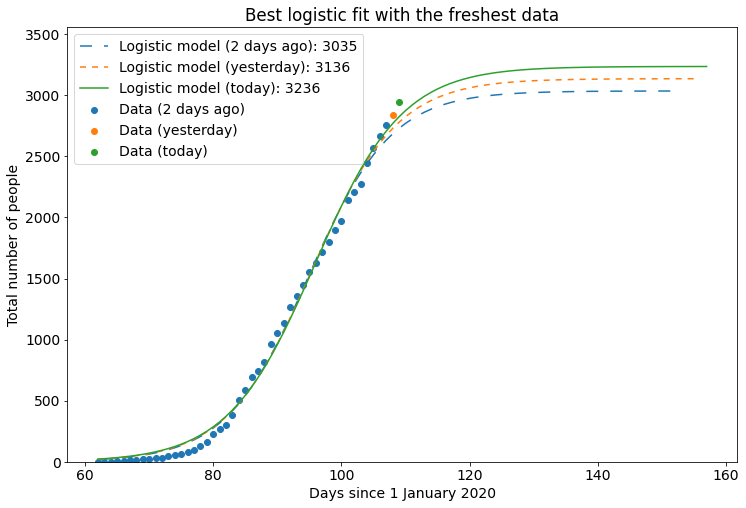

In [10]:
plt.rc('font', size=14)


def add_real_data(df, label,column = 'cases', color=None):
    x = df['day'].tolist()
    y = df[column].tolist()
    plt.scatter(x, y, label="Data (" + label + ")", c=color)


def add_logistic_curve(df, label,column = 'cases', **kwargs):
    x, _, speed, x_peak, y_max, _, _, end, _ = predict_logistic_maximum(df, column)
    x_range = list(range(min(x), end))
    plt.plot(x_range,
             [logistic_model(i, speed, x_peak, y_max) for i in x_range],
             label="Logistic model (" + label + "): " + str(int(round(y_max))),
             **kwargs)
    return y_max


def label_and_show_plot(plt, title, y_max=None):
    plt.title(title)
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of people")
    if (y_max):
        plt.ylim(0, y_max * 1.1)
    plt.legend()
    plt.show()


# Plot
plt.figure(figsize=(12, 8))
add_real_data(df[:-2], "2 days ago")
add_real_data(df[-2:-1], "yesterday")
add_real_data(df[-1:], "today")
add_logistic_curve(df[:-2], "2 days ago", dashes=[8, 8])
add_logistic_curve(df[:-1], "yesterday", dashes=[4, 4])
y_max = add_logistic_curve(df, "today")
label_and_show_plot(plt, "Best logistic fit with the freshest data", y_max)

### Plot 2. What changed since 2 days ago that steered the count up.
The growth "slowdown" stopped, staying for many days as a perfect exponential (1.25^x), lifting the amplitude of the Logistic fit.

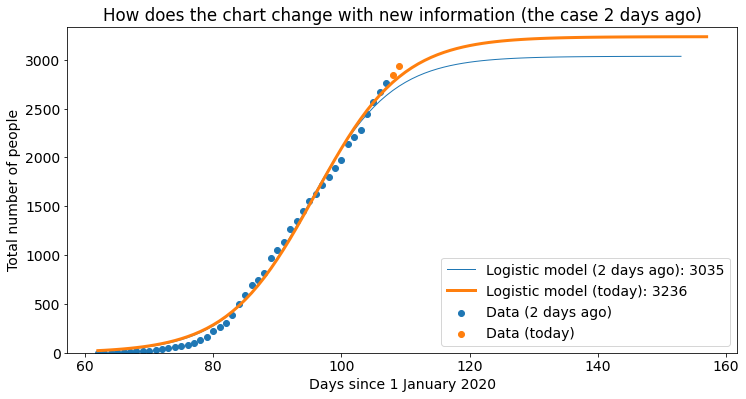

In [12]:
plt.figure(figsize=(12, 6))
add_real_data(df[:-2], "2 days ago")
add_real_data(df[-2:], "today")
y_max = add_logistic_curve(df[:-2], "2 days ago", linewidth=1)
add_logistic_curve(df, "today", linewidth=3)
label_and_show_plot(plt, "How does the chart change with new information (the case 2 days ago)", y_max)

### Experiment 1: discarding noisy initial samples
Try discarding points at the beginning to see how it affects the prediction.


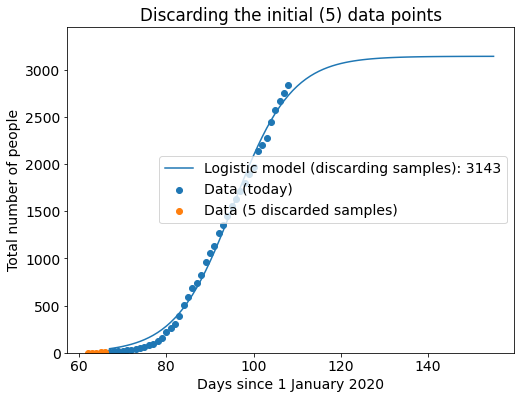

Today Discarding the initial (5) data points's prediction: maximum cases : 3143 (± 97), peak at calendar day: 2020-04-06 00:00:00 (± 0.54), ending on day: 2020-06-06 00:00:00



In [0]:
#@title Try it yourself { run: "auto", vertical-output: true, form-width: "620px", display-mode: "form" }
points_to_discard = 5 #@param {type:"slider", min:0, max:15, step:1}

# Plot: discard initial data points
plt.figure(figsize=(8, 6))
pts = points_to_discard
add_real_data(df[pts:], "today")
add_real_data(df[:pts], str(pts) + " discarded samples")
y_max = add_logistic_curve(df[pts:], "discarding samples")
label_and_show_plot(plt, "Discarding the initial (" + str(pts) + ") data points", y_max)
pred = print_prediction(df[pts:], "Today Discarding the initial (" + str(pts) + ") data points")
print()
html_print("As of today, the total infection should stabilize at <b>" + str(int(round(pred))) + "</b>")


# Exponential model
While the logistic model describes ain infection growth that is going to stop in the future, The exponential model describes an unstoppable infection growth. For example, if a patient infects 2 patients per day, after 1 day we’ll have 2 infections, 4 after 2 days, 8 after 3 and so on.

The most generic exponential function is:

![texto alternativo](https://miro.medium.com/max/259/1*WlL6AmIK1wX8C78qjsTEHg.png)

The variable x is the time and we still have the parameters a, b, c. The meaning, however, is different from the logistic function parameters’.
Let’s define the function in Python and let’s perform the same curve fitting procedure used for logistic growth.

In [0]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [0]:
# fit the data to the model (find the model variables that best approximate)
def predict_exponential_maximum(df, column = 'cases'):
    samples = df.shape[0]
    x_days = df['day'].tolist()
    y_cases = df[column].tolist()
    speed_guess = 2.5
    peak_guess = 120
    amplitude_guess = 250000
    
    initial_guess =speed_guess, peak_guess, amplitude_guess

    fit = curve_fit(exponential_model, x_days, y_cases,p0=initial_guess)

    # parse the result of the fit
    speed, x_peak, y_max = fit[0]
    speed_error, x_peak_error, y_max_error = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]

    # find the "end date", as the x (day of year) where the function reaches 99.99%
    end = int(fsolve(lambda x: exponential_model(x, speed, x_peak, y_max) - y_max * 0.9999, x_peak))

    return x_days, y_cases, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples

In [0]:
pred = print_prediction(df, "today", model='exponential')
print()
html_print("As of today, the total infection should stabilize at <b>" + str(int(round(pred))) + " </b> (Exponential Model)")

today's prediction: maximum cases : 250000 (± -9223372036854775808), peak at calendar day: 2020-05-01 00:00:00 (± inf), ending on day: 2020-05-01 00:00:00



/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# Deaths
We cannot trust the number of confirmed cases without knowing the number of tests performed per day. 


Taking the number of deaths we can do another type of analysis.

In [15]:
print_prediction(df[:-2], "2 days ago", 'deaths')
print_prediction(df[:-1], "yesterday", 'deaths')
pred = print_prediction(df, "today", 'deaths')
print()
html_print("As of today, the total deaths should stabilize at <b>" + str(int(round(pred))) + "</b>")

2 days ago's prediction: maximum deaths : 160 (± 6), peak at calendar day: 2020-04-11 00:00:00 (± 0.5), ending on day: 2020-06-02 00:00:00
yesterday's prediction: maximum deaths : 162 (± 5), peak at calendar day: 2020-04-11 00:00:00 (± 0.44), ending on day: 2020-06-02 00:00:00
today's prediction: maximum deaths : 161 (± 4), peak at calendar day: 2020-04-11 00:00:00 (± 0.38), ending on day: 2020-06-02 00:00:00



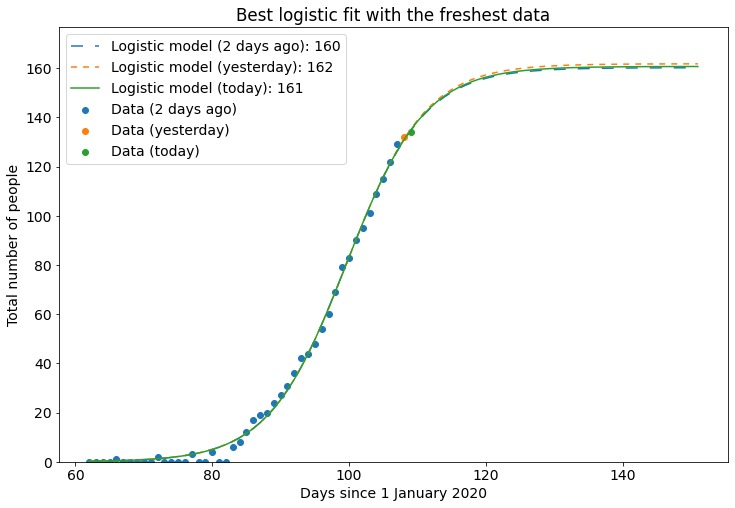

In [17]:
# Plot
plt.figure(figsize=(12, 8))
add_real_data(df[:-2], "2 days ago", column = 'deaths')
add_real_data(df[-2:-1], "yesterday", column = 'deaths')
add_real_data(df[-1:], "today", column = 'deaths')
add_logistic_curve(df[:-2], "2 days ago",column='deaths', dashes=[8, 8])
add_logistic_curve(df[:-1], "yesterday",column='deaths', dashes=[4, 4])
y_max = add_logistic_curve(df, "today", column='deaths')
label_and_show_plot(plt, "Best logistic fit with the freshest data", y_max)

# Conclusions
Come back to see the result on live data. We'll update every day. The noise in the input makes it hard to predict which part of the logistic curve are we in. In the next few days the predicitons will start converging.
